
# Handwritten Digit Recognition - Deep Neural Networks
## Notebook by <a href="https://github.com/agnivahp"><u>Agnivah Poddar</u></a>
### University of Illinois - Urbana Champaign
---

## Table of Contents
1. <a href='#Intro'>Introduction</a>
2. <a href='#License'>License</a>
3. <a href='#Req'>Required Libraries</a>
4. Problem domain
5. Step 1
5. Step 2
5. Step 3
5. Step 4
6. Conclusions
7. References
8. Acknowledgements

---

<a id='Intro'></a>
## Introduction
In this notebook, we will progressively build and improve a neural network that recognizes hand-written digits all the way to 99% accuracy. 

As we build and train the network, we will discover the tools that are used to model deep neural networks efficiently and learn about some tricks that can be used to improve the performance. 
We will be using the famous MNIST dataset which consists of 60,000 labeled handwritten digits. We will start with a simple one layer network and add more layers to go on to build a more complex 5 layered convolutional network.

---

<a id='License'></a>
## License

---

<a id='Req'></a>
## Required Libraries
We will need the following for this demo:
- Python3
- Tensorflow
- Matplotlib

You can install the latest version of python 3 from https://www.python.org/downloads/

If you are a MacOS user like me, you can use the following commands:
```bash
 pip3 install --upgrade tensorflow
 pip3 install --upgrade matplotlib
```
If you wish to use some other specific environment, visit tensorflow.org and follow the Python 3 instructions.

---

## Problem Domain
Our aim is to create a demo machine learning model that trains itself based off the MNIST digits and is able to recognize any handwritten digit given to it with maximum accuracy. 

Our dataset looks like this:

![dataset](https://kuanhoong.files.wordpress.com/2016/01/mnistdigits.gif "Digits from the dataset")


We have the digits along with their correct labels which will be used for training the network. We also have another set of digits that the network has not seen before. Our network should be able to correctly recognize and classify these new digits.

---

In [1]:
#tensorflow demo Digit recognition
%matplotlib inline

import tensorflow as tf
import tensorflowvisu
import math
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

import logging
logging.basicConfig(filename='intermediate.log',level=logging.DEBUG)

# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = read_data_sets("data", one_hot=True, reshape=False, validation_size=0)


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


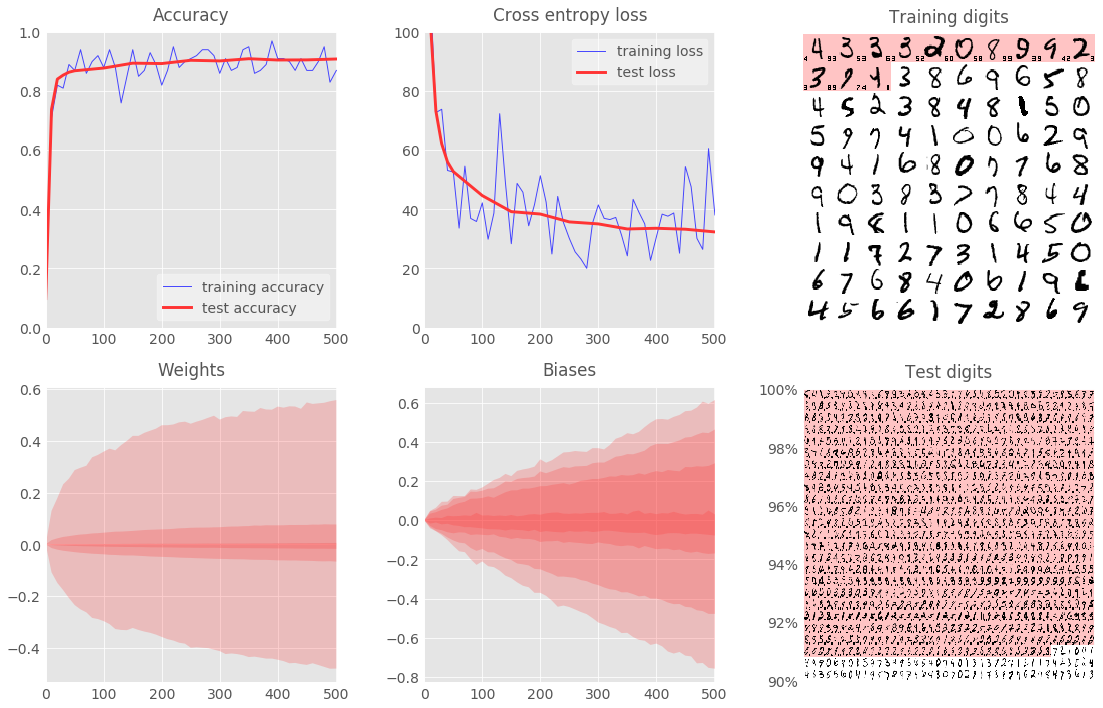

test accuracy: 90.95%


In [2]:
#placeholder for training set
X = tf.placeholder(tf.float32, [None, 28, 28, 1])

#variables to be determined
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

#model
Y = tf.nn.softmax(tf.matmul(tf.reshape(X,[-1, 784]), W) + b)
#placeholder for correct labels
Y_ = tf.placeholder(tf.float32, [None, 10])

#loss function that needs to be minimized
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y))*1000.0

# % of correct answers found in batch
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

#optimizer
optimizer = tf.train.GradientDescentOptimizer(0.003)
train_step = optimizer.minimize(cross_entropy)


# matplotlib visualisation
allweights = tf.reshape(W, [-1])
allbiases = tf.reshape(b, [-1])
I = tensorflowvisu.tf_format_mnist_images(X, Y, Y_)  # assembles 10x10 images by default
It = tensorflowvisu.tf_format_mnist_images(X, Y, Y_, 1000, lines=25)  # 1000 images on 25 lines
datavis = tensorflowvisu.MnistDataVis()


#training
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# You can call this function in a loop to train the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # compute training values for visualisation
    if update_train_data:
        a, c, im, w, b = sess.run([accuracy, cross_entropy, I, allweights, allbiases], feed_dict={X: batch_X, Y_: batch_Y})
        datavis.append_training_curves_data(i, a, c)
        datavis.append_data_histograms(i, w, b)
        datavis.update_image1(im)
        logging.debug(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))
        #logging.info('So should this')
        #print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))

    # compute test values for visualisation
    if update_test_data:
        a, c, im = sess.run([accuracy, cross_entropy, It], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        datavis.append_test_curves_data(i, a, c)
        datavis.update_image2(im)
        logging.debug(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        #print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})

#animation
datavis.animate(training_step, iterations=500+1, train_data_update_freq=10, test_data_update_freq=50, more_tests_at_start=True)

print("test accuracy: " + str(float(str(datavis.get_max_test_accuracy()))*100) + '%')



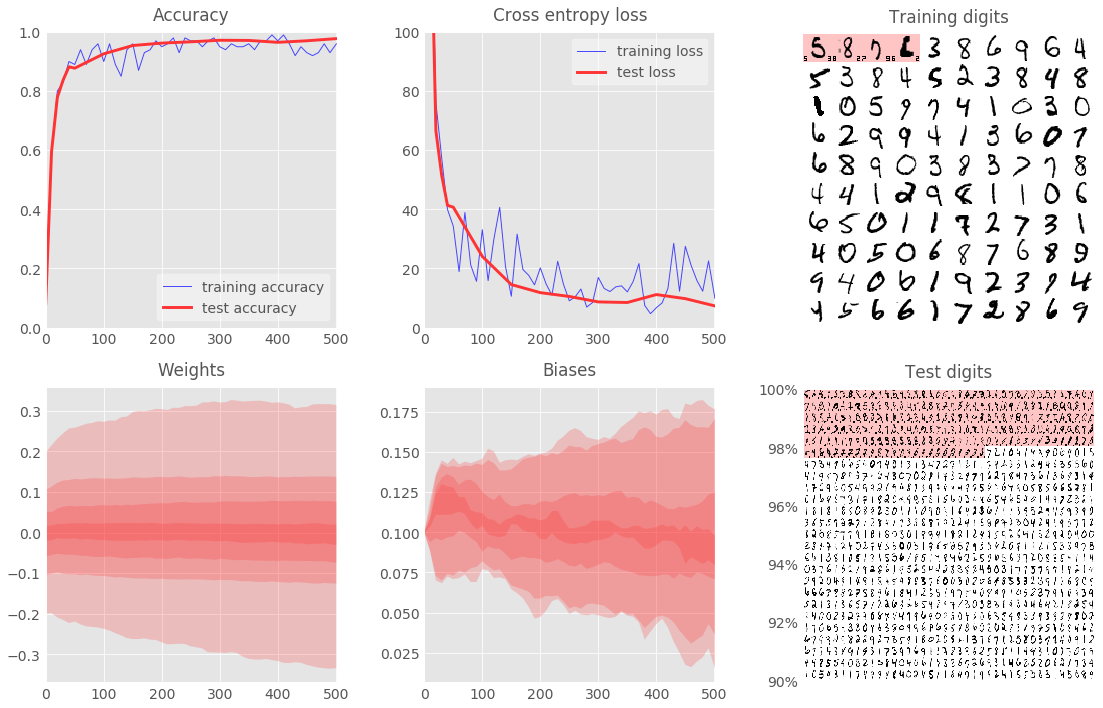

Test accuracy: 0.9775


In [2]:
#tensorflow demo Digit recognition
#CNN

import math

#placeholder for training set
X = tf.placeholder(tf.float32, [None, 28, 28, 1])

#learning rate exponentially decaying
learningRate = tf.placeholder(tf.float32)

#variables to be determined
# w = tf.Variable(tf.zeros([784,10]))
# b = tf.Variable(tf.zeros([10]))
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
B1 = tf.Variable(tf.ones([4])/10) # 2 is the number of output channels

W2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
B2 = tf.Variable(tf.ones([8])/10) # 2 is the number of output channels

W3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B3 = tf.Variable(tf.ones([12])/10) # 2 is the number of output channels

W4 = tf.Variable(tf.truncated_normal([7*7*12, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10) # 2 is the number of output channels

W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10) # 2 is the number of output channels



# Y = tf.nn.softmax(tf.matmul(tf.reshape(X,[-1, 784]), w) + b)
#XX = tf.reshape(X, [-1, 28*28])

#dropout to take care of overfitting
pkeep = tf.placeholder(tf.float32)

#model
stride = 1  # output is still 28x28
Y1cnv = tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME')
Y1 = tf.nn.relu(Y1cnv + B1)
#Y1d = tf.nn.dropout(Y1, pkeep)
stride = 2
Y2cnv = tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME')
Y2 = tf.nn.relu(Y2cnv + B2)
#Y2d = tf.nn.dropout(Y2, pkeep)
stride = 2
Y3cnv = tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME')
Y3 = tf.nn.relu(Y3cnv + B3)
#Y3d = tf.nn.dropout(Y3, pkeep)

YY = tf.reshape(Y3, shape=[-1, 7*7*12])
Y4 = tf.nn.relu(tf.matmul(YY,W4) + B4)
Y4d = tf.nn.dropout(Y4, pkeep)

Ylogits = tf.matmul(Y4d, W5) + B5
Y = tf.nn.softmax(Ylogits)
#Y5cnv = tf.nn.conv2d(Y4d, W5, strides=[1, stride, stride, 1], padding='SAME')
#Y5 = tf.nn.relu(Y5cnv + B5)
#Y5d = tf.nn.dropout(Y5, pkeep)



#placeholder for correct labels
Y_ = tf.placeholder(tf.float32, [None, 10])

#loss function that needs to be minimized

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# % of correct answers found in batch
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

#optimizer
optimizer = tf.train.AdamOptimizer(learningRate)
train_step = optimizer.minimize(cross_entropy)


# matplotlib visualisation
allweights = tf.concat([tf.reshape(W1, [-1]), tf.reshape(W2, [-1])], 0)
allbiases  = tf.concat([tf.reshape(B1, [-1]), tf.reshape(B2, [-1])], 0)
I = tensorflowvisu.tf_format_mnist_images(X, Y, Y_)  # assembles 10x10 images by default
It = tensorflowvisu.tf_format_mnist_images(X, Y, Y_, 1000, lines=25)  # 1000 images on 25 lines
datavis = tensorflowvisu.MnistDataVis()


#training
lrmin = 0.0001
lrmax = 0.003
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


#Training the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    lr = lrmin+(lrmax-lrmin)*math.exp(-i/2000)
    # compute training values for visualisation
    if update_train_data:
        a, c, im, w, b = sess.run([accuracy, cross_entropy, I, allweights, allbiases], feed_dict={X: batch_X, Y_: batch_Y, learningRate: lr, pkeep: 0.75})
        datavis.append_training_curves_data(i, a, c)
        datavis.append_data_histograms(i, w, b)
        datavis.update_image1(im)
        logging.debug(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))
        #print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))

    # compute test values for visualisation
    if update_test_data:
        a, c, im = sess.run([accuracy, cross_entropy, It], feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep: 1})
        datavis.append_test_curves_data(i, a, c)
        datavis.update_image2(im)
        logging.debug(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        #print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, learningRate: lr, pkeep: 0.75})


#to animate plots
datavis.animate(training_step, iterations=500+1, train_data_update_freq=10, test_data_update_freq=50, more_tests_at_start=True)

#for i in range(10000+1):
 #   training_step(i, i % 50 == 0, i % 10 == 0)

print("Test accuracy: " + str(datavis.get_max_test_accuracy()))


## Conclusion

---

## Acknowledgements

---